In [1]:
# Process GCMs (Graph Centrality Measures) on dbpedia data 

# Installing packages
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install networkx
!pip install rdflib
!pip install mlnotify

# Importing packages
import pandas as pd
#from SPARQLWrapper import SPARQLWrapper, JSON, N3
#import lxml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx import Graph as NXGraph
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import statistics
import collections

#import danker # https://github.com/athalhammer/danker
from scipy import stats
from urllib import parse

import mlnotify 
# https://github.com/aporia-ai/mlnotify
# Use %%notify at beginning of cell

import os.path, time
# Use %%time at beginning of cell

print('------------')
!python --version
print("Pandas " + pd.__version__)
print("Numpy " + np.__version__)
#print("Seaborn " + sns.__version__)
print("Networkx " + nx.__version__)
print('------------')
print("All packages loaded and ready to roll :-)")

------------
Python 3.9.7
Pandas 1.4.2
Numpy 1.22.3
Networkx 2.8
------------
All packages loaded and ready to roll :-)


In [2]:
#load GCM data

#df_pr = pd.read_csv("../keseitz/data/PageRank/df_pr.csv")
#df_pr.head()

df_gcm = pd.read_csv("../keseitz/data/PageRank/gcm-metrics1.csv")
df_gcm.head()

,resource,degree,pagerank
0,http://dbpedia.org/resource/Boss_(rapper),1.334412e-06,5.202821e-08
1,http://dbpedia.org/resource/Def_Jam_Recordings,1.265265e-04,8.024377e-06
2,http://dbpedia.org/resource/Great_Mazinger,1.091792e-06,3.370992e-07
3,http://dbpedia.org/resource/Masayuki_Akechi,1.213102e-07,2.965359e-08
4,http://dbpedia.org/resource/Rafael_Trujillo__T...,4.852407e-07,5.954646e-08


In [4]:
# (OLD) Method for splitting the resource to get resource/name (based of the URI) to match PageRank dataframe

def node_path (row):
    return parse.urlsplit(row['resource']).path.split('/', 1)[-1]

In [12]:
#pr_total = df_pr['pagerank'].sum()
pr_total = df_gcm['pagerank'].sum()
print("PageRank normalized probability distribution:")
print (pr_total)
# -> Normalverteilung um 1 rum (Durchschnitt ist 1 wie es bei PageRank sein sollte -> test auf Normalverteilung

PageRank normalized probability distribution:
1.0000000000005405


In [5]:
print(8243333*7.805755e-08)

0.64345437781415


## Get DBpedia categories

In [14]:
# Query DBpedia via API to get all EU capitals from the "Category": Capitals_in_Europe

#import rdflib
#g = rdflib.Graph()
#qres = g.query(
#    """
#    PREFIX skos: <http://www.w3.org/2004/02/skos/core#broader>
#    PREFIX dct: <http://purl.org/dc/terms/> 
#    PREFIX dbc: <http://dbpedia.org/resource/Category:>
#    PREFIX dbo: <http://dbpedia.org/ontology/>
#    PREFIX dbp: <http://dbpedia.org/property/>
#    PREFIX dbr: <http://dbpedia.org/resource/>


#    SELECT ?euCap
#    WHERE {
#      SERVICE <http://dbpedia.org/sparql> {
#        ?euCap a dbo:City ;
#          dct:subject dbc:Capitals_in_Europe .
#      }
#    }
#    """
#)

#for row in qres:
#    print(row.s)

In [5]:
%%time

# Alternative load presaved (via queried web-interface) DBpedia

# 90s films from the aggregated Categories: 1990_films, 1991_films, 1992_films, ...
df_film90 = pd.read_csv("../keseitz/data/sparqlQueries/sparql_90film.csv")
df_film90.rename(columns={"90film": "resource"}, inplace=True) #rename column to match PageRank dataframe
#df_film90['resource'] = df_film90.apply(lambda row: node_path(row), axis=1) #split resource to get resource/name (based on URI) to match PageRank dataframe


# actors from the "Occupation": "Actor"@en
df_actor = pd.read_csv("../keseitz/data/sparqlQueries/sparql_actor.csv")
df_actor.rename(columns={"actor": "resource"}, inplace=True)
#df_actor['resource'] = df_actor.apply(lambda row: node_path(row), axis=1)


# Music Genre from the "Type": "dbo:MusicGenre"
df_musicGenre = pd.read_csv("../keseitz/data/sparqlQueries/sparql_musicGenre.csv")
df_musicGenre.rename(columns={"mGenre": "resource"}, inplace=True)
#df_musicGenre['resource'] = df_musicGenre.apply(lambda row: node_path(row), axis=1)


# Books from the "Type":"dbo:book"
df_book = pd.read_csv("../keseitz/data/sparqlQueries/sparql_book.csv")
df_book.rename(columns={"book": "resource"}, inplace=True)
#df_book['resource'] = df_book.apply(lambda row: node_path(row), axis=1)


# Book authors from the "Type": author UNION book dbo:author
df_bookAut = pd.read_csv("../keseitz/data/sparqlQueries/sparql_bookAuthor.csv")
df_bookAut.rename(columns={"author": "resource"}, inplace=True)
#df_bookAut['resource'] = df_bookAut.apply(lambda row: node_path(row), axis=1)


# Politicians from the "Type": Person/Politician
df_pol = pd.read_csv("../keseitz/data/sparqlQueries/sparql_politician.csv")
df_pol.rename(columns={"pol": "resource"}, inplace=True)
#df_pol['resource'] = df_pol.apply(lambda row: node_path(row), axis=1)


# POTUS from the "Category": Presidents_of_the_United_States
df_potus = pd.read_csv("../keseitz/data/sparqlQueries/sparql_potus.csv")
df_potus.rename(columns={"potus": "resource"}, inplace=True)
#df_potus['resource'] = df_potus.apply(lambda row: node_path(row), axis=1)


# Cities from the "Category": "dbo:City"
df_city = pd.read_csv("../keseitz/data/sparqlQueries/sparql_city.csv")
df_city.rename(columns={"city": "resource"}, inplace=True)
#df_city['resource'] = df_city.apply(lambda row: node_path(row), axis=1)


# Lakes from the "Category": "dbo:Lake"
df_lake = pd.read_csv("../keseitz/data/sparqlQueries/sparql_lake.csv")
df_lake.rename(columns={"lake": "resource"}, inplace=True)
#df_lake['resource'] = df_lake.apply(lambda row: node_path(row), axis=1)


# Mountains from the "Category": "dbo:Mountain"
df_mountain = pd.read_csv("../keseitz/data/sparqlQueries/sparql_mountain.csv")
df_mountain.rename(columns={"mount": "resource"}, inplace=True)
#df_mountain['resource'] = df_mountain.apply(lambda row: node_path(row), axis=1)


# EU capitals from the "Category": Capitals_in_Europe
df_euCap = pd.read_csv("../keseitz/data/sparqlQueries/sparql_euCap.csv")
df_euCap.rename(columns={"euCap": "resource"}, inplace=True)
#df_euCap['resource'] = df_euCap.apply(lambda row: node_path(row), axis=1)


# EU countries from the "Category": Countries_in_Europe
df_euCou = pd.read_csv("../keseitz/data/sparqlQueries/sparql_euCountry.csv")
df_euCou.rename(columns={"euCountry": "resource"}, inplace=True)
#df_euCou['resource'] = df_euCou.apply(lambda row: node_path(row), axis=1)


# Asian countries from the "Category": "dbc:Countries_in_Asia", "dbc:East_Asian_countries" and "dbc:Central_Asian_countries"
df_asCou = pd.read_csv("../keseitz/data/sparqlQueries/sparql_asCountry.csv")
df_asCou.rename(columns={"asCountry": "resource"}, inplace=True)
#df_asCou['resource'] = df_asCou.apply(lambda row: node_path(row), axis=1)


# Continents from the "Category": "dbo:Continents"
df_continent = pd.read_csv("../keseitz/data/sparqlQueries/sparql_continent.csv")
df_continent.rename(columns={"conti": "resource"}, inplace=True)
#df_continent['resource'] = df_continent.apply(lambda row: node_path(row), axis=1)


# Birds from the "Class": "dbr:Bird"
df_bird = pd.read_csv("../keseitz/data/sparqlQueries/sparql_bird.csv")
df_bird.rename(columns={"bird": "resource"}, inplace=True)
#df_bird['resource'] = df_bird.apply(lambda row: node_path(row), axis=1)


# African animals from the "Category": "dbc:Vertebrates_of_Africa"
df_africanAnimal = pd.read_csv("../keseitz/data/sparqlQueries/sparql_africanAnimal.csv")
df_africanAnimal.rename(columns={"afrAnimal": "resource"}, inplace=True)
#df_africanAnimal['resource'] = df_africanAnimal.apply(lambda row: node_path(row), axis=1)


# Furniture from the "Category": "dbc:Furniture"
df_furniture = pd.read_csv("../keseitz/data/sparqlQueries/sparql_furniture.csv")
df_furniture.rename(columns={"fur": "resource"}, inplace=True)
#df_furniture['resource'] = df_furniture.apply(lambda row: node_path(row), axis=1)


# Furniture from the "Category": "dbc:Vegetables"
df_vegetable = pd.read_csv("../keseitz/data/sparqlQueries/sparql_vegetable.csv")
df_vegetable.rename(columns={"veg": "resource"}, inplace=True)
#df_vegetable['resource'] = df_vegetable.apply(lambda row: node_path(row), axis=1)


# Types of fast food from the "Category": "dbc:Fast_food"
df_fastFood = pd.read_csv("../keseitz/data/sparqlQueries/sparql_fastfood.csv")
df_fastFood.rename(columns={"fastFood": "resource"}, inplace=True)
#df_fastFood['resource'] = df_fastFood.apply(lambda row: node_path(row), axis=1)


# European Landmark/Sight from multiple "Category": "dbc:Landmarks_in_x" with x being a country from europe
df_euSight = pd.read_csv("../keseitz/data/sparqlQueries/sparql_euLandmark.csv")
df_euSight.rename(columns={"euroSight": "resource"}, inplace=True)
#df_euSight['resource'] = df_euSight.apply(lambda row: node_path(row), axis=1)


# DAX company from the "Type": "dbo:Company" and "dbp:tradedAs" -> "dbr:DAX"
df_daxCo = pd.read_csv("../keseitz/data/sparqlQueries/sparql_daxCompany.csv")
df_daxCo.rename(columns={"DAXco": "resource"}, inplace=True)
#df_daxCo['resource'] = df_daxCo.apply(lambda row: node_path(row), axis=1)


# US company from ?
df_usCo = pd.read_csv("../keseitz/data/sparqlQueries/sparql_usCompany.csv")
df_usCo.rename(columns={"USCo": "resource"}, inplace=True)
#df_usCo['resource'] = df_usCo.apply(lambda row: node_path(row), axis=1)


# US tech company from the "Category": "dbc:Technology_companies_of_the_United_States"
df_usTechCo = pd.read_csv("../keseitz/data/sparqlQueries/sparql_usTechCompany.csv")
df_usTechCo.rename(columns={"usTech": "resource"}, inplace=True)
#df_usTechCo['resource'] = df_usTechCo.apply(lambda row: node_path(row), axis=1)

CPU times: user 404 ms, sys: 48.8 ms, total: 453 ms
Wall time: 473 ms


In [8]:
#df_euCap['resource'] = df_euCap.apply(lambda row: node_path(row), axis=1)

#df_euCap.head()

,resource,name
0,resource/European_Capital_of_Culture,European Capital of Culture
1,resource/Podgorica,Podgorica
2,resource/City_of_San_Marino,City of San Marino
3,resource/Kyiv,Kyiv
4,resource/Amsterdam,Amsterdam


### 90s film

In [8]:
%%time

# Merge the DFs based on resource with an Left Merge / Left Outer Join
# (Keep every row in the left dataframe. Missing values get NaN)

# 90s films
film90_result = pd.merge(df_film90,
                 df_pr[['resource_id','resource', 'pagerank']],
                 on='resource', 
                 how='left')

film90_result['resource'] = film90_result.apply(lambda row: node_path(row), axis=1)
film90_result.size

CPU times: user 22.5 s, sys: 1.67 s, total: 24.1 s
Wall time: 23.9 s


40000

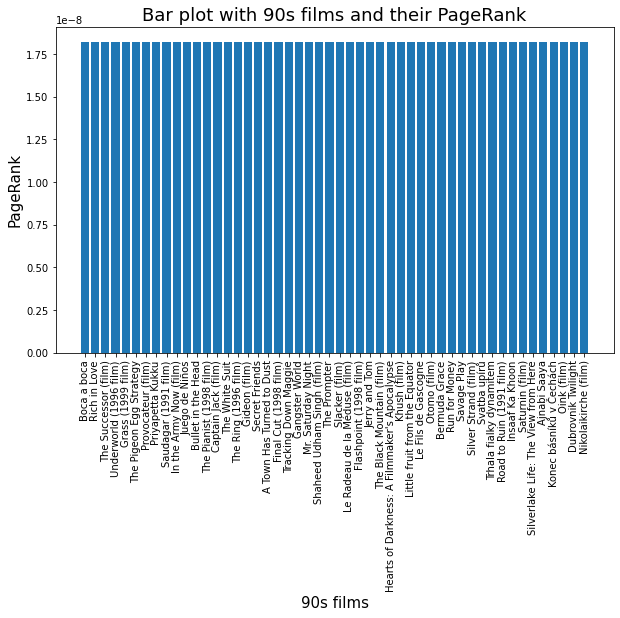

In [9]:
film90_sorted = film90_result.sort_values('pagerank')
film90_sorted = film90_sorted.head(50)


plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('name', 'pagerank',data=film90_sorted)
plt.xlabel("90s films", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with 90s films and their PageRank", size=18)
plt.savefig("../keseitz/plots/film90_barplot_PR_asc.png", bbox_inches="tight")

### Actor

In [10]:
# actor
actor_result = pd.merge(df_actor,
                 df_pr[['resource_id','resource', 'pagerank']],
                 on='resource', 
                 how='left')

actor_result['resource'] = actor_result.apply(lambda row: node_path(row), axis=1)
actor_result.size

40000

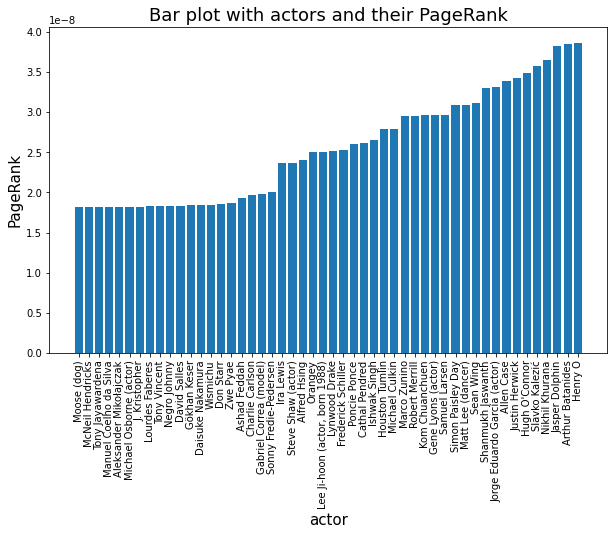

In [11]:
actor_sorted = actor_result.sort_values('pagerank')
actor_sorted = actor_sorted.head(50)


plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('name', 'pagerank',data=actor_sorted)
plt.xlabel("actor", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with actors and their PageRank", size=18)
plt.savefig("../keseitz/plots/actor_barplot_PR_asc.png", bbox_inches="tight")

### EU capital

In [19]:
# EU capitals

# Merge the DFs based on resource with an Left Merge / Left Outer Join
# (Keep every row in the left dataframe. Missing values get NaN)

euCap_result = pd.merge(df_euCap,
                 #df_pr[['resource_id','resource', 'pagerank']],
                 df_gcm[['resource', 'degree','pagerank']],
                 on='resource', 
                 how='left')

#euCap_result['resource'] = euCap_result.apply(lambda row: node_path(row), axis=1)
euCap_result = euCap_result.drop(0) # custom for EU capitals as value with index 0 is a faulty entry

euCap_result

,resource,name,degree,pagerank
1,http://dbpedia.org/resource/Podgorica,Podgorica,6.004853e-05,6.215473e-06
2,http://dbpedia.org/resource/City_of_San_Marino,City of San Marino,1.140316e-05,1.392710e-06
3,http://dbpedia.org/resource/Kyiv,Kyiv,2.552366e-04,3.266771e-05
4,http://dbpedia.org/resource/Amsterdam,Amsterdam,3.773959e-04,5.877084e-05
5,http://dbpedia.org/resource/Athens,Athens,2.847150e-04,3.651685e-05
6,http://dbpedia.org/resource/Berlin,Berlin,6.037607e-04,8.670599e-05
7,http://dbpedia.org/resource/Copenhagen,Copenhagen,4.168217e-04,7.165694e-05
8,http://dbpedia.org/resource/Dublin,Dublin,6.200163e-04,8.493329e-05
9,http://dbpedia.org/resource/Helsinki,Helsinki,2.807117e-04,4.386219e-05
10,http://dbpedia.org/resource/Lisbon,Lisbon,2.523252e-04,3.448612e-05


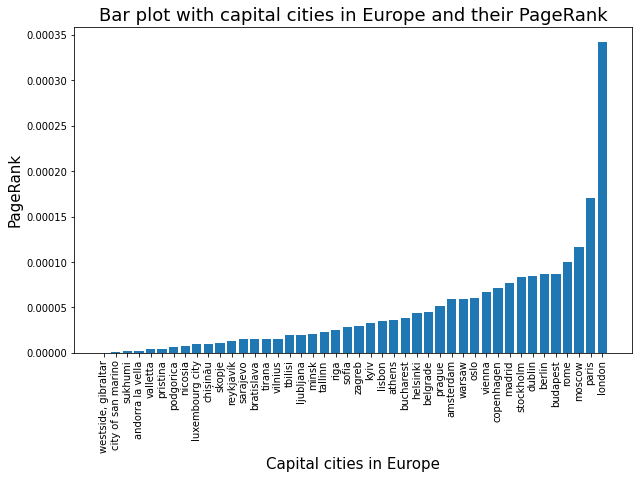

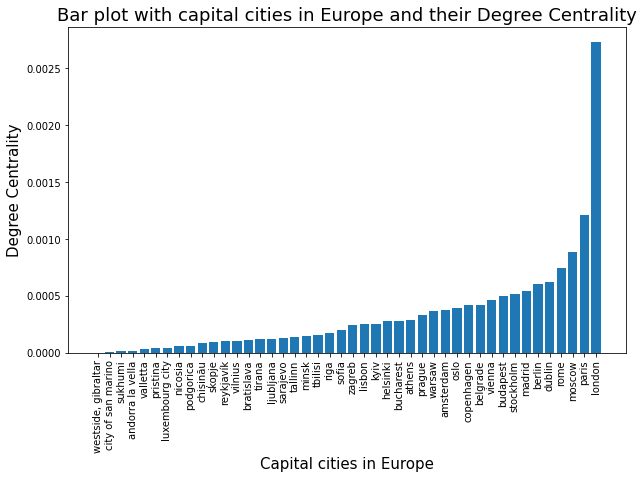

In [25]:
# Barplot PageRank
euCap_PR_sorted = euCap_result.sort_values('pagerank')

plt.figure(figsize=(10,6))
plt.bar('name', 'pagerank',data=euCap_PR_sorted)
plt.xlabel("Capital cities in Europe", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with capital cities in Europe and their PageRank", size=18)
plt.savefig("../keseitz/plots/euCap_barplot_PR_asc.png", bbox_inches="tight")

# Barplot Degree Centrality
euCap_DG_sorted = euCap_result.sort_values('degree')

plt.figure(figsize=(10,6))
plt.bar('name', 'degree',data=euCap_DG_sorted)
plt.xlabel("Capital cities in Europe", size=15)
plt.xticks(rotation=90)
plt.ylabel("Degree Centrality", size=15)
plt.title("Bar plot with capital cities in Europe and their Degree Centrality", size=18)
plt.savefig("../keseitz/plots/euCap_barplot_DG_asc.png", bbox_inches="tight")


In [22]:
# read survey data into dataframe
df_survey_euCap = pd.read_csv("../keseitz/data/df_european_capital_cities_trans.csv", sep=';')

df_survey_euCap['european_capital_cities'] = df_survey_euCap['european_capital_cities'].replace('kiev','kyiv', regex=True).replace('reykjavik','reykjavík', regex=True).replace('valetta','valletta', regex=True)

df_survey_euCap.head()

,european_capital_cities,p_age,p_gender,p_education,p_country,p_id
0,berlin,26,Male,Bachelor's degree,germany,0
1,paris,26,Male,Bachelor's degree,germany,0
2,london,26,Male,Bachelor's degree,germany,0
3,amsterdam,44,Male,Doctorate (e.g. PhD),germany,1
4,berlin,44,Male,Doctorate (e.g. PhD),germany,1


In [26]:
#count how often an answer was given in the survey and save into new dataframe
counted_survey_euCap = df_survey_euCap['european_capital_cities'].value_counts()

df_euCap_survey_counted = pd.DataFrame({'name':counted_survey_euCap.index, 'amount':counted_survey_euCap.values})

euCap_result.name = euCap_result.name.str.lower()

df_euCap_survey_gcm = pd.merge(df_euCap_survey_counted,
                 euCap_result[['name', 'degree','pagerank']],
                 on='name', 
                 how='left')

# assign all answers that were not matchable a PR of 0 (altough per definition of PR not possible) to allow plotting. Alternative: drop from df?
#df_euCap_survey_gcm.pagerank = df_euCap_survey_gcm.pagerank.fillna(0)
#df_euCap_survey_gcm.degree = df_euCap_survey_gcm.degree.fillna(0)


#euCap_result['resource'] = euCap_result.apply(lambda row: node_path(row), axis=1)
df_euCap_survey_gcm

,name,amount,degree,pagerank
0,berlin,84,0.000604,0.000087
1,paris,74,0.001208,0.000170
2,london,45,0.002729,0.000342
3,rome,29,0.000749,0.000099
4,madrid,19,0.000546,0.000077
5,vienna,9,0.000461,0.000067
6,brussels,8,NaN,NaN
7,warsaw,7,0.000370,0.000059
8,copenhagen,7,0.000417,0.000072
9,helsinki,5,0.000281,0.000044


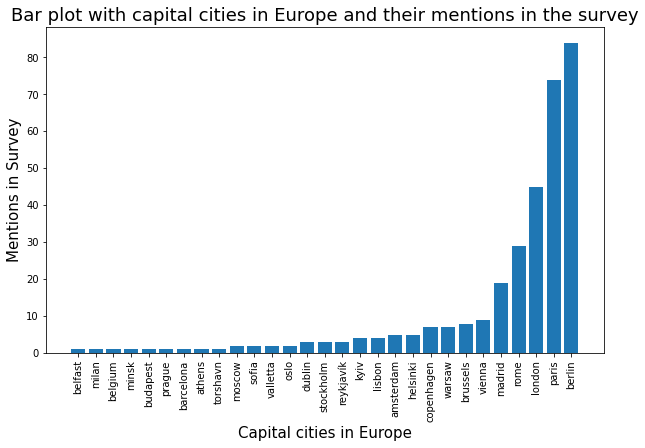

In [27]:
df_euCap_survey_counted_and_sorted = df_euCap_survey_counted.sort_values('amount')

plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('name', 'amount',data=df_euCap_survey_counted_and_sorted)
plt.xlabel("Capital cities in Europe", size=15)
plt.xticks(rotation=90)
plt.ylabel("Mentions in Survey", size=15)
plt.title("Bar plot with capital cities in Europe and their mentions in the survey", size=18)
plt.savefig("../keseitz/plots/euCapital_barplot_SV_asc.png", bbox_inches="tight")

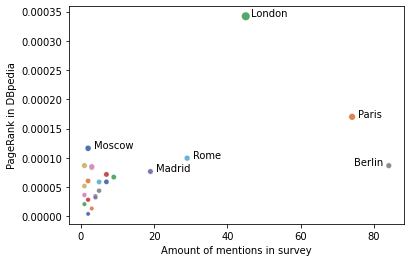

In [32]:
# Scatterplot between PageRank and Survey Results for EU capital cities
sns.scatterplot(data=df_euCap_survey_gcm, x="amount", y="pagerank", size="pagerank", legend=False, hue="pagerank", palette="deep")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='berlin']-9.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='berlin'],"Berlin")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='paris']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='paris'],"Paris")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='london']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='london'],"London")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='moscow']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='moscow'],"Moscow")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='rome']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='rome'],"Rome")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='madrid']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='madrid'],"Madrid")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='budapest']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='budapest'],"Budapest")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='stockholm']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='stockholm'],"Stockholm")

#plt.title('Scatter plot with EU capital cities and their PageRank', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('PageRank in DBpedia')


#for i in range(df_euCap_survey_pr.shape[0]):
 #   plt.text(x=df_euCap_survey_pr.amount[i]+0.3,y=df_euCap_survey_pr.pagerank[i]+0.3,s=df_euCap_survey_pr.name[i], fontdict=dict(color='red',size=10), bbox=dict(facecolor='yellow',alpha=0.5))
#plt.xticks(rotation=90);
plt.savefig("../keseitz/plots/euCap_scatterplot_SurveyXpr_asc.png", bbox_inches="tight")

Text(0, 0.5, 'Degree Centrality in DBpedia')

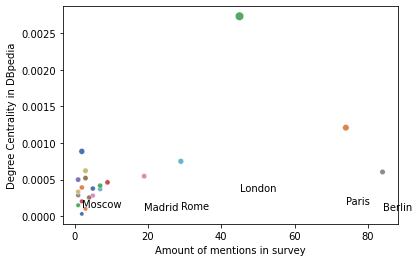

In [35]:
# Scatterplot between Degree Centrality and Survey Results for EU capital cities
sns.scatterplot(data=df_euCap_survey_gcm, x="amount", y="degree", size="degree", legend=False, hue="degree", palette="deep")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='berlin'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='berlin'],"Berlin")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='paris'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='paris'],"Paris")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='london'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='london'],"London")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='moscow'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='moscow'],"Moscow")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='rome'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='rome'],"Rome")
plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='madrid'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='madrid'],"Madrid")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='budapest']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='budapest'],"Budapest")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='stockholm']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='stockholm'],"Stockholm")

#plt.title('Scatter plot with EU capital cities and their PageRank', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('Degree Centrality in DBpedia')


#for i in range(df_euCap_survey_pr.shape[0]):
 #   plt.text(x=df_euCap_survey_pr.amount[i]+0.3,y=df_euCap_survey_pr.pagerank[i]+0.3,s=df_euCap_survey_pr.name[i], fontdict=dict(color='red',size=10), bbox=dict(facecolor='yellow',alpha=0.5))
#plt.xticks(rotation=90);
#plt.savefig("../keseitz/plots/euCap_scatterplot_SurveyXdg_asc.png", bbox_inches="tight")

In [36]:
euCap_result.name = euCap_result.name.str.lower()
euCap_result.rename(columns={"name": "european_capital_cities"}, inplace=True)


euCap_result

,resource,european_capital_cities,degree,pagerank
1,http://dbpedia.org/resource/Podgorica,podgorica,6.004853e-05,6.215473e-06
2,http://dbpedia.org/resource/City_of_San_Marino,city of san marino,1.140316e-05,1.392710e-06
3,http://dbpedia.org/resource/Kyiv,kyiv,2.552366e-04,3.266771e-05
4,http://dbpedia.org/resource/Amsterdam,amsterdam,3.773959e-04,5.877084e-05
5,http://dbpedia.org/resource/Athens,athens,2.847150e-04,3.651685e-05
6,http://dbpedia.org/resource/Berlin,berlin,6.037607e-04,8.670599e-05
7,http://dbpedia.org/resource/Copenhagen,copenhagen,4.168217e-04,7.165694e-05
8,http://dbpedia.org/resource/Dublin,dublin,6.200163e-04,8.493329e-05
9,http://dbpedia.org/resource/Helsinki,helsinki,2.807117e-04,4.386219e-05
10,http://dbpedia.org/resource/Lisbon,lisbon,2.523252e-04,3.448612e-05


In [43]:
euCap_survey_pr = pd.merge(df_survey_euCap,
                 euCap_result[['european_capital_cities', 'pagerank']],
                 on='european_capital_cities', 
                 how='left')

euCap_survey_pr

KeyError: "['european_capital_cities'] not in index"

,european_capital_cities,p_age,p_gender,p_education,p_country,p_id,pagerank
172,minsk,29,Prefer not to say,Master's degree,germany,57,0.000021
256,sofia,25,Female,Master's degree,germany,85,0.000028
297,sofia,26,Female,High school degree or equivalent,germany,99,0.000028
231,lisbon,51,Male,High school degree or equivalent,germany,77,0.000034
106,lisbon,25,Female,Bachelor's degree,germany,35,0.000034
...,...,...,...,...,...,...,...
259,brussels,25,Female,Bachelor's degree,russia,86,NaN
264,kiev,26,Male,Bachelor's degree,germany,88,NaN
293,reykjavik,26,Male,Less than a high school degree,germany,98,NaN
302,barcelona,23,Female,Master's degree,england,101,NaN


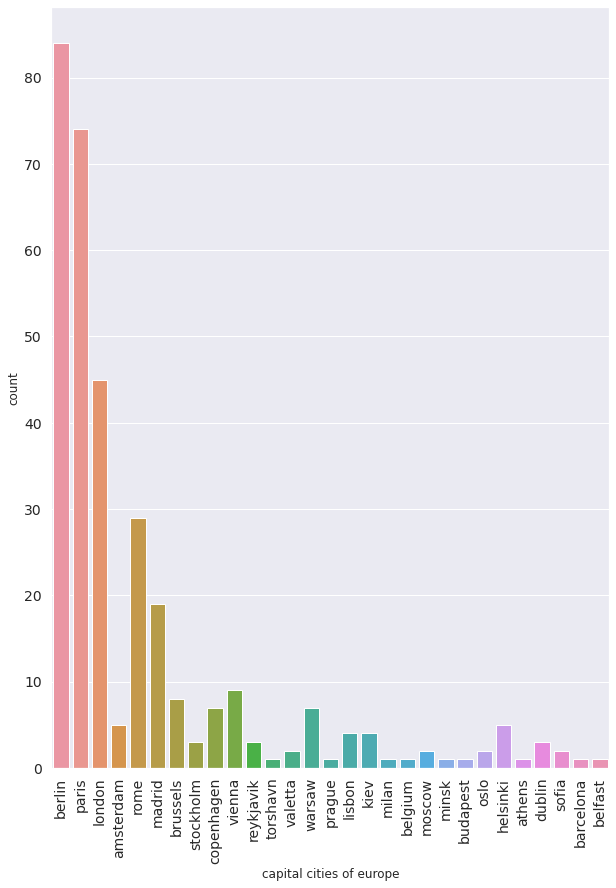

In [13]:
# Plot european capital cities
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='european_capital_cities', data=euCap_survey_pr)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);
plt.xlabel('capital cities of europe')
plt.tick_params(labelsize=14)


euCap_survey_pr_sorted = euCap_survey_pr.sort_values('pagerank')

euCap_survey_pr_sorted

### EU country

In [18]:
# EU countries
euCou_result = pd.merge(df_euCou,
                 df_pr[['resource_id','resource', 'pagerank']],
                 on='resource', 
                 how='left')

euCou_result['resource'] = euCou_result.apply(lambda row: node_path(row), axis=1)
euCou_result.size

204

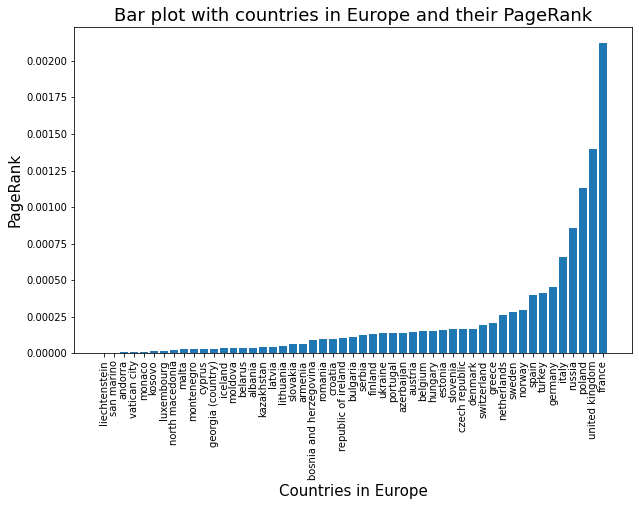

In [35]:
euCou_sorted = euCou_result.sort_values('pagerank')

plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('name', 'pagerank',data=euCou_sorted)
plt.xlabel("Countries in Europe", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with countries in Europe and their PageRank", size=18)
plt.savefig("../keseitz/plots/euCountry_barplot_PR_asc.png", bbox_inches="tight")

In [20]:
# read survey data into dataframe
df_survey_euCou = pd.read_csv("../keseitz/data/df_european_countries_trans.csv", sep=';')

#df_survey_euCou['european_countries'] = df_survey_euCou['european_countries'].replace('uk','united kingdom', regex=True).replace('ireland','republic of ireland', regex=True).replace('greatbritain','united kingdom', regex=True)

df_survey_euCou.head()

,european_countries,p_age,p_gender,p_education,p_country,p_id
0,germany,26,Male,Bachelor's degree,germany,0
1,france,26,Male,Bachelor's degree,germany,0
2,italy,26,Male,Bachelor's degree,germany,0
3,germany,44,Male,Doctorate (e.g. PhD),germany,1
4,france,44,Male,Doctorate (e.g. PhD),germany,1


In [21]:
#count how often an answer was given in the survey and save into new dataframe
counted_survey_euCou = df_survey_euCou['european_countries'].value_counts()

df_euCou_survey_counted = pd.DataFrame({'name':counted_survey_euCou.index, 'amount':counted_survey_euCou.values})

euCou_result.name = euCou_result.name.str.lower()

df_euCou_survey_pr = pd.merge(df_euCou_survey_counted,
                 euCou_result[['name', 'pagerank']],
                 on='name', 
                 how='left')

# assign all answers that were not matchable a PR of 0 (altough per definition of PR not possible) to allow plotting. Alternative: drop from df?
df_euCou_survey_pr.pagerank = df_euCou_survey_pr.pagerank.fillna(0)

#euCap_result['resource'] = euCap_result.apply(lambda row: node_path(row), axis=1)
df_euCou_survey_pr

,name,amount,pagerank
0,germany,80,0.000457
1,france,66,0.002124
2,italy,38,0.000656
3,spain,30,0.000400
4,united kingdom,13,0.001394
5,poland,13,0.001131
6,austria,12,0.000149
7,switzerland,11,0.000191
8,sweden,11,0.000279
9,denmark,10,0.000169


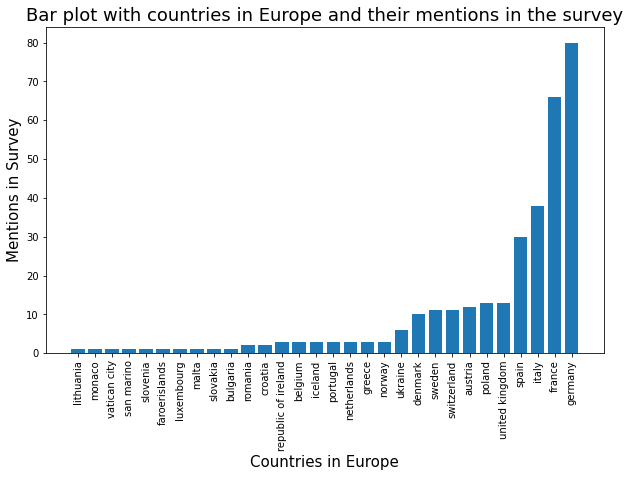

In [36]:
df_euCou_survey_counted_and_sorted = df_euCou_survey_counted.sort_values('amount')

plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('name', 'amount',data=df_euCou_survey_counted_and_sorted)
plt.xlabel("Countries in Europe", size=15)
plt.xticks(rotation=90)
plt.ylabel("Mentions in Survey", size=15)
plt.title("Bar plot with countries in Europe and their mentions in the survey", size=18)
plt.savefig("../keseitz/plots/euCountry_barplot_SV_asc.png", bbox_inches="tight")

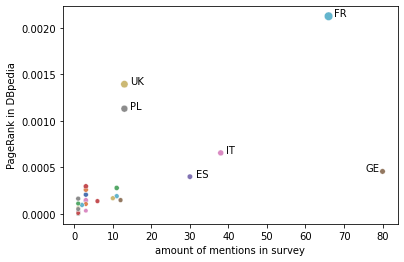

In [23]:
sns.scatterplot(data=df_euCou_survey_pr, x="amount", y="pagerank", size="pagerank", legend=False, hue="pagerank", palette="deep")
plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='germany']-4.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='germany'],"GE")
plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='france']+1.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='france'],"FR")
plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='italy']+1.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='italy'],"IT")
plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='spain']+1.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='spain'],"ES")
plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='united kingdom']+1.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='united kingdom'],"UK")
plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='poland']+1.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='poland'],"PL")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='budapest']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='budapest'],"Budapest")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='stockholm']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='stockholm'],"Stockholm")

#plt.title('Scatter plot with EU capital cities and their PageRank', size=18)
plt.xlabel('amount of mentions in survey')
plt.ylabel('PageRank in DBpedia')


#for i in range(df_euCap_survey_pr.shape[0]):
 #   plt.text(x=df_euCap_survey_pr.amount[i]+0.3,y=df_euCap_survey_pr.pagerank[i]+0.3,s=df_euCap_survey_pr.name[i], fontdict=dict(color='red',size=10), bbox=dict(facecolor='yellow',alpha=0.5))
#plt.xticks(rotation=90);
plt.savefig("../keseitz/plots/euCou_scatterplot_SurveyXpr_asc.png", bbox_inches="tight")

### Book authors

In [24]:
# Book Authors
bookAut_result = pd.merge(df_bookAut,
                 df_pr[['resource_id','resource', 'pagerank']],
                 on='resource', 
                 how='left')

bookAut_result['resource'] = bookAut_result.apply(lambda row: node_path(row), axis=1)
bookAut_result.size

17580

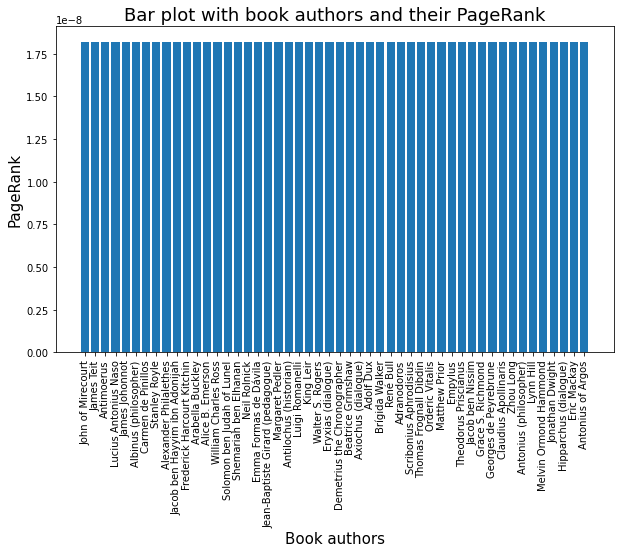

In [25]:
bookAut_sorted = bookAut_result.sort_values('pagerank')
bookAut_sorted = bookAut_sorted.head(50)



plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('name', 'pagerank',data=bookAut_sorted)
plt.xlabel("Book authors", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with book authors and their PageRank", size=18)
plt.savefig("../keseitz/plots/books_barplot_PR_asc.png", bbox_inches="tight")

### Politicians

In [26]:
# Politicians
pol_result = pd.merge(df_pol,
                 df_pr[['resource_id','resource', 'pagerank']],
                 on='resource', 
                 how='left')

pol_result['resource'] = pol_result.apply(lambda row: node_path(row), axis=1)
pol_result.size

40000

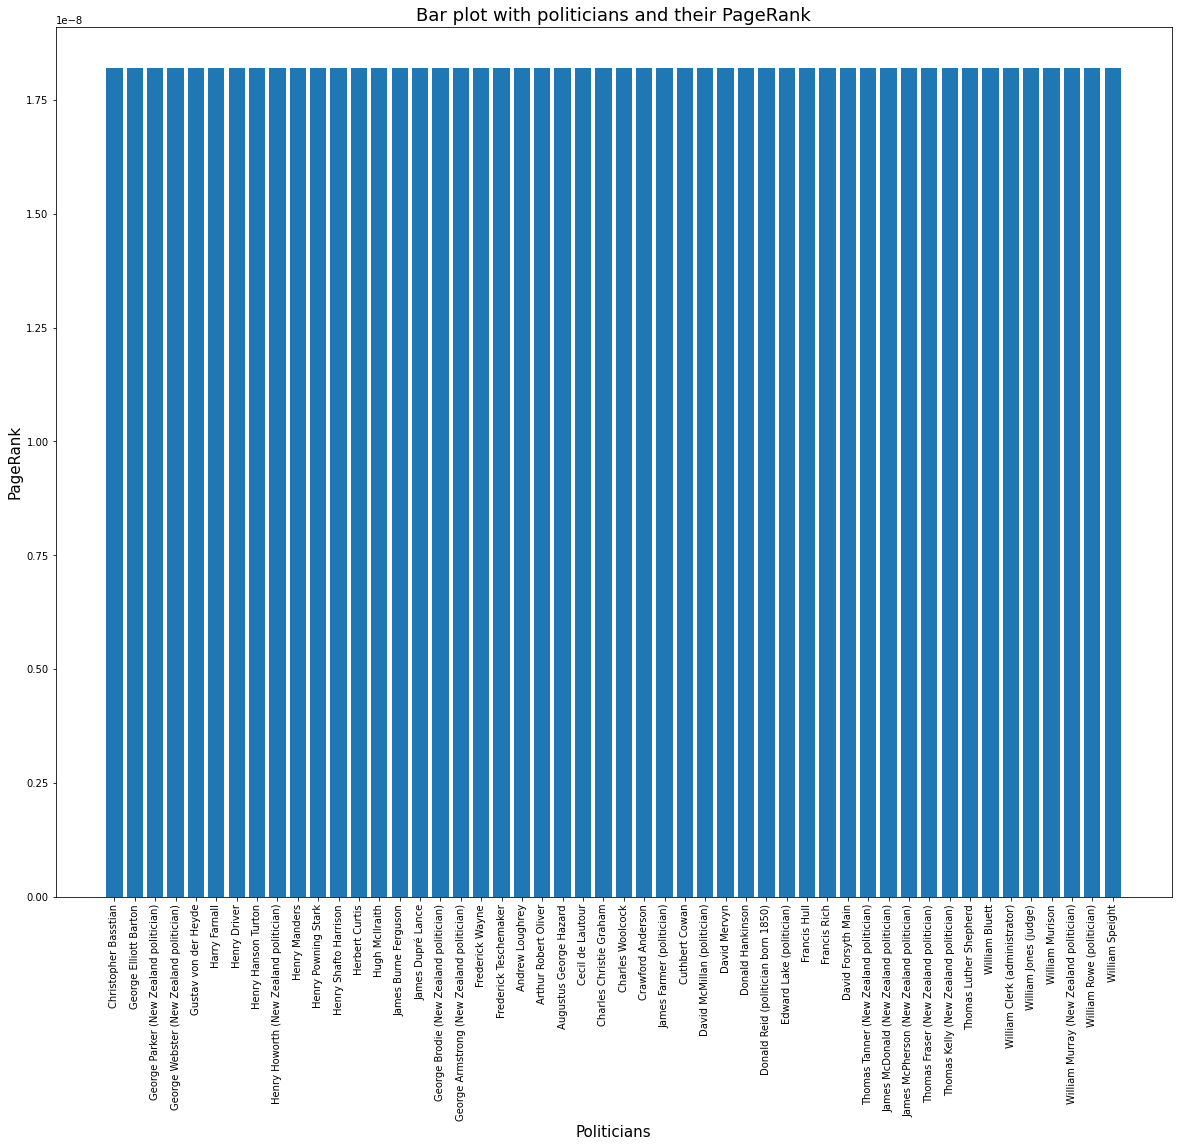

In [27]:
pol_sorted = pol_result.sort_values('pagerank')
pol_sorted = pol_sorted.head(50)

plt.figure(figsize=(20,16))
# bar plot with matplotlib
plt.bar('name', 'pagerank',data=pol_sorted)
plt.xlabel("Politicians", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with politicians and their PageRank", size=18)
plt.savefig("../keseitz/plots/politician_barplot_PR_asc.png", bbox_inches="tight")

In [28]:
pol_sorted

,resource,name,resource_id,pagerank
4999,Christopher_Basstian,Christopher Basstian,6824798,1.819710e-08
5291,George_Elliott_Barton,George Elliott Barton,1274558,1.819710e-08
5309,George_Parker_(New_Zealand_politician),George Parker (New Zealand politician),6881458,1.819710e-08
5310,George_Webster_(New_Zealand_politician),George Webster (New Zealand politician),3808829,1.819710e-08
5346,Gustav_von_der_Heyde,Gustav von der Heyde,6227990,1.819710e-08
5369,Harry_Farnall,Harry Farnall,131528,1.819710e-08
5391,Henry_Driver,Henry Driver,7672199,1.819710e-08
5393,Henry_Hanson_Turton,Henry Hanson Turton,7802888,1.819710e-08
5396,Henry_Howorth_(New_Zealand_politician),Henry Howorth (New Zealand politician),8043238,1.819710e-08
5399,Henry_Manders,Henry Manders,4632659,1.819710e-08


### POTUS

In [29]:
# Potus
potus_result = pd.merge(df_potus,
                 #df_pr[['resource_id','resource', 'pagerank']],
                 df_gcm[['resource_id','resource', 'degree','pagerank']],
                 on='resource', 
                 how='left')

potus_result['resource'] = potus_result.apply(lambda row: node_path(row), axis=1)
potus_result.size

184

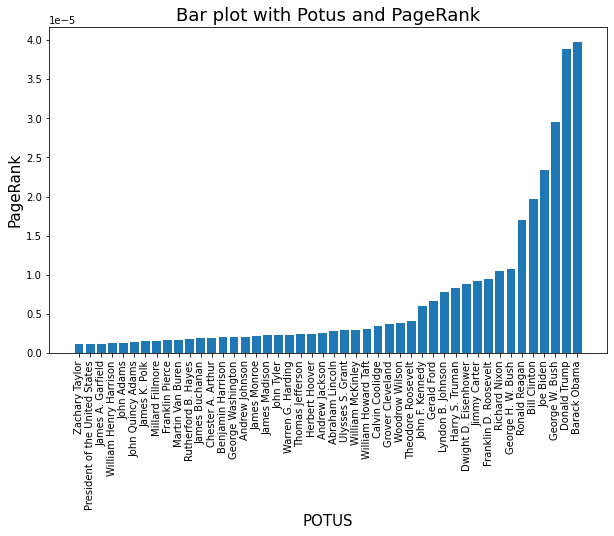

In [34]:
potus_sorted = potus_result.sort_values('pagerank')
#pol_sorted = pol_sorted.head(50)

plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('name', 'pagerank',data=potus_sorted)
plt.xlabel("POTUS", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with Potus and PageRank", size=18)
plt.savefig("../keseitz/plots/potus_barplot_PR_asc.png.png", bbox_inches="tight")

In [31]:
potus_sorted

,resource,name,resource_id,pagerank
44,Zachary_Taylor,Zachary Taylor,123718,0.000001
25,President_of_the_United_States,President of the United States,745097,0.000001
23,James_A._Garfield,James A. Garfield,767463,0.000001
32,William_Henry_Harrison,William Henry Harrison,784308,0.000001
38,John_Adams,John Adams,183467,0.000001
18,John_Quincy_Adams,John Quincy Adams,240516,0.000001
14,James_K._Polk,James K. Polk,104453,0.000002
42,Millard_Fillmore,Millard Fillmore,164683,0.000002
39,Franklin_Pierce,Franklin Pierce,66193,0.000002
19,Martin_Van_Buren,Martin Van Buren,204626,0.000002
